In [97]:
import os
import pandas as pd
import numpy as np
import json
import pickle
from collections import defaultdict
from pathlib import Path
from statistics import mean, stdev
from sklearn.metrics import ndcg_score, dcg_score
import matplotlib.pyplot as plt
import seaborn as sns

import torch

import os, sys
parentPath = os.path.abspath("..")
if parentPath not in sys.path:
    sys.path.insert(0, parentPath)
    
from src.data import load_source
from src.config import Config, get_option_fallback
from src.path import get_best_model_paths, get_exp_paths, get_report_path, load_json, load_rep_cfg
from knowledge_tracing.trainer import Trainer

In [3]:
projectdir = Path('/code')
assert projectdir.exists()

# Common Functions

In [162]:
def summarize_test_res(rep, folds=5):
    print(rep['config']['exp_name'], end=':\t')
    s = pd.Series([rep['best']['auc_epoch'][str(i)] for i in range(folds)])
    print(f'Best epoch at {s.mean():>6.1f}±{s.std():<5.1f}', end='\t')
    s = pd.Series([rep['best']['auc'][str(i)] for i in range(folds)])
    print(f'Valid AUC: {s.mean()*100:.4f}±{s.std()*100:.4f}', end='\t')
    s = pd.Series([rep['indicator']['test_auc'][str(i)][0] for i in range(folds)])
    print(f'Test AUC: {s.mean()*100:.4f}±{s.std()*100:.4f}', end='\t')
    s = rep['indicator']['test_auc']['all'][0]
    print(f'All Test AUC: {s*100:.4f}')

In [143]:
def show_valid_lc(name, idclist_dic, idc='eval_auc'):
    min_len = min([len(_x) for _x in idclist_dic['epoch'].values()])
    x = idclist_dic['epoch']['0'][:min_len] * (len(idclist_dic['epoch']) -1)  # exclude 'all'
    y = []
    for _y in idclist_dic[idc].values():
        y += _y[:min_len]
    sns.lineplot(x=x, y=y, label=name)
    plt.title(idc)

# AUC comparison

In [ ]:
results = [
    'output/20_0218_edm2020_asmt0910/pre_dummy_epoch_size0.auto/report/20200220-0823/ksdkt.json',
    'output/20_0218_edm2020_asmt0910/pre_dummy_epoch_size10.auto/report/20200220-0535/ksdkt.json',
    'output/20_0218_edm2020_asmt0910/pre_dummy_epoch_size150.auto/report/20200220-0431/ksdkt.json',
    
    'output/20_0222_edm2020_asmt15/pre_dummy_epoch_size0.auto/report/20200223-1405/report.json',
    'output/20_0222_edm2020_asmt15/pre_dummy_epoch_size10.auto/report/20200223-0724/report.json',
    'output/20_0222_edm2020_asmt15/pre_dummy_epoch_size150.auto/report/20200223-0354/report.json',
]

In [27]:
df = pd.DataFrame(columns=['dataset', 'model', 'pre', 'bestepoch', 'AUC', 'std'])
df = pd.DataFrame(columns=['dataset', 'pre', 'AUC', 'std'])

for res_path in results:
    with open(projectdir / res_path, 'r') as f:
        res = json.load(f)
    row = {
        'dataset':   res['config']['source_data'],
#         'model':     res['config']['model_name']+'/'+res['config']['exp_name'],
        'pre':       res['config']['pre_dummy_epoch_size'],
#         'bestepoch': np.mean(list(res['best']['auc_epoch'].values())),
        'AUC':       np.mean(list(res['best']['auc'].values())),
        'std':       np.std(list(res['best']['auc'].values())),
    }
    df = df.append(row, ignore_index=True)
    
df

,dataset,pre,AUC,std
0,original_ASSISTmentsSkillBuilder0910,0,0.827841,0.032821
1,original_ASSISTmentsSkillBuilder0910,10,0.831144,0.031850
2,original_ASSISTmentsSkillBuilder0910,150,0.830445,0.031801
3,2015_100_skill_builders_main_problems,0,0.690579,0.003041
4,2015_100_skill_builders_main_problems,10,0.691871,0.002877
5,2015_100_skill_builders_main_problems,150,0.692713,0.003017


In [28]:
print(df.to_latex())

\begin{tabular}{lllrr}
\toprule
{} &                                dataset &  pre &       AUC &       std \\
\midrule
0 &   original\_ASSISTmentsSkillBuilder0910 &    0 &  0.827841 &  0.032821 \\
1 &   original\_ASSISTmentsSkillBuilder0910 &   10 &  0.831144 &  0.031850 \\
2 &   original\_ASSISTmentsSkillBuilder0910 &  150 &  0.830445 &  0.031801 \\
3 &  2015\_100\_skill\_builders\_main\_problems &    0 &  0.690579 &  0.003041 \\
4 &  2015\_100\_skill\_builders\_main\_problems &   10 &  0.691871 &  0.002877 \\
5 &  2015\_100\_skill\_builders\_main\_problems &  150 &  0.692713 &  0.003017 \\
\bottomrule
\end{tabular}



# `20_0310_edm2020_assist09`

## Simulated curve

In [138]:
config_name = '20_0310_edm2020_assist09'
report_list = []
for r in sorted([load_json(get_report_path(projectdir, e)) for e in get_exp_paths(projectdir, config_name)], key=lambda x: x['config']['pre_dummy_epoch_size']):
    report_list.append(r)

[r['config']['exp_name'] for r in report_list]

['pre_dummy_epoch_size0.auto',
 'pre_dummy_epoch_size10.auto',
 'pre_dummy_epoch_size150.auto']

In [150]:
def get_simu_res(report_dic):
    return report_dic['indicator']['simu_pred']['all']

simures_list = []
for r in report_list:
    simu_res = get_simu_res(r)
    simures_list.append(simu_res)
    
base_idx = 0
base_res = {k:v for k, v in sorted(simures_list[base_idx].items(), key=lambda it: it[1][1][-1] - it[1][1][0])}
descres_list = []
for i, simu_res in enumerate(simures_list):
    if i == base_idx:
        continue
    desc_res = {k:simu_res[k] for k in base_res.keys()}
    descres_list.append(desc_res)

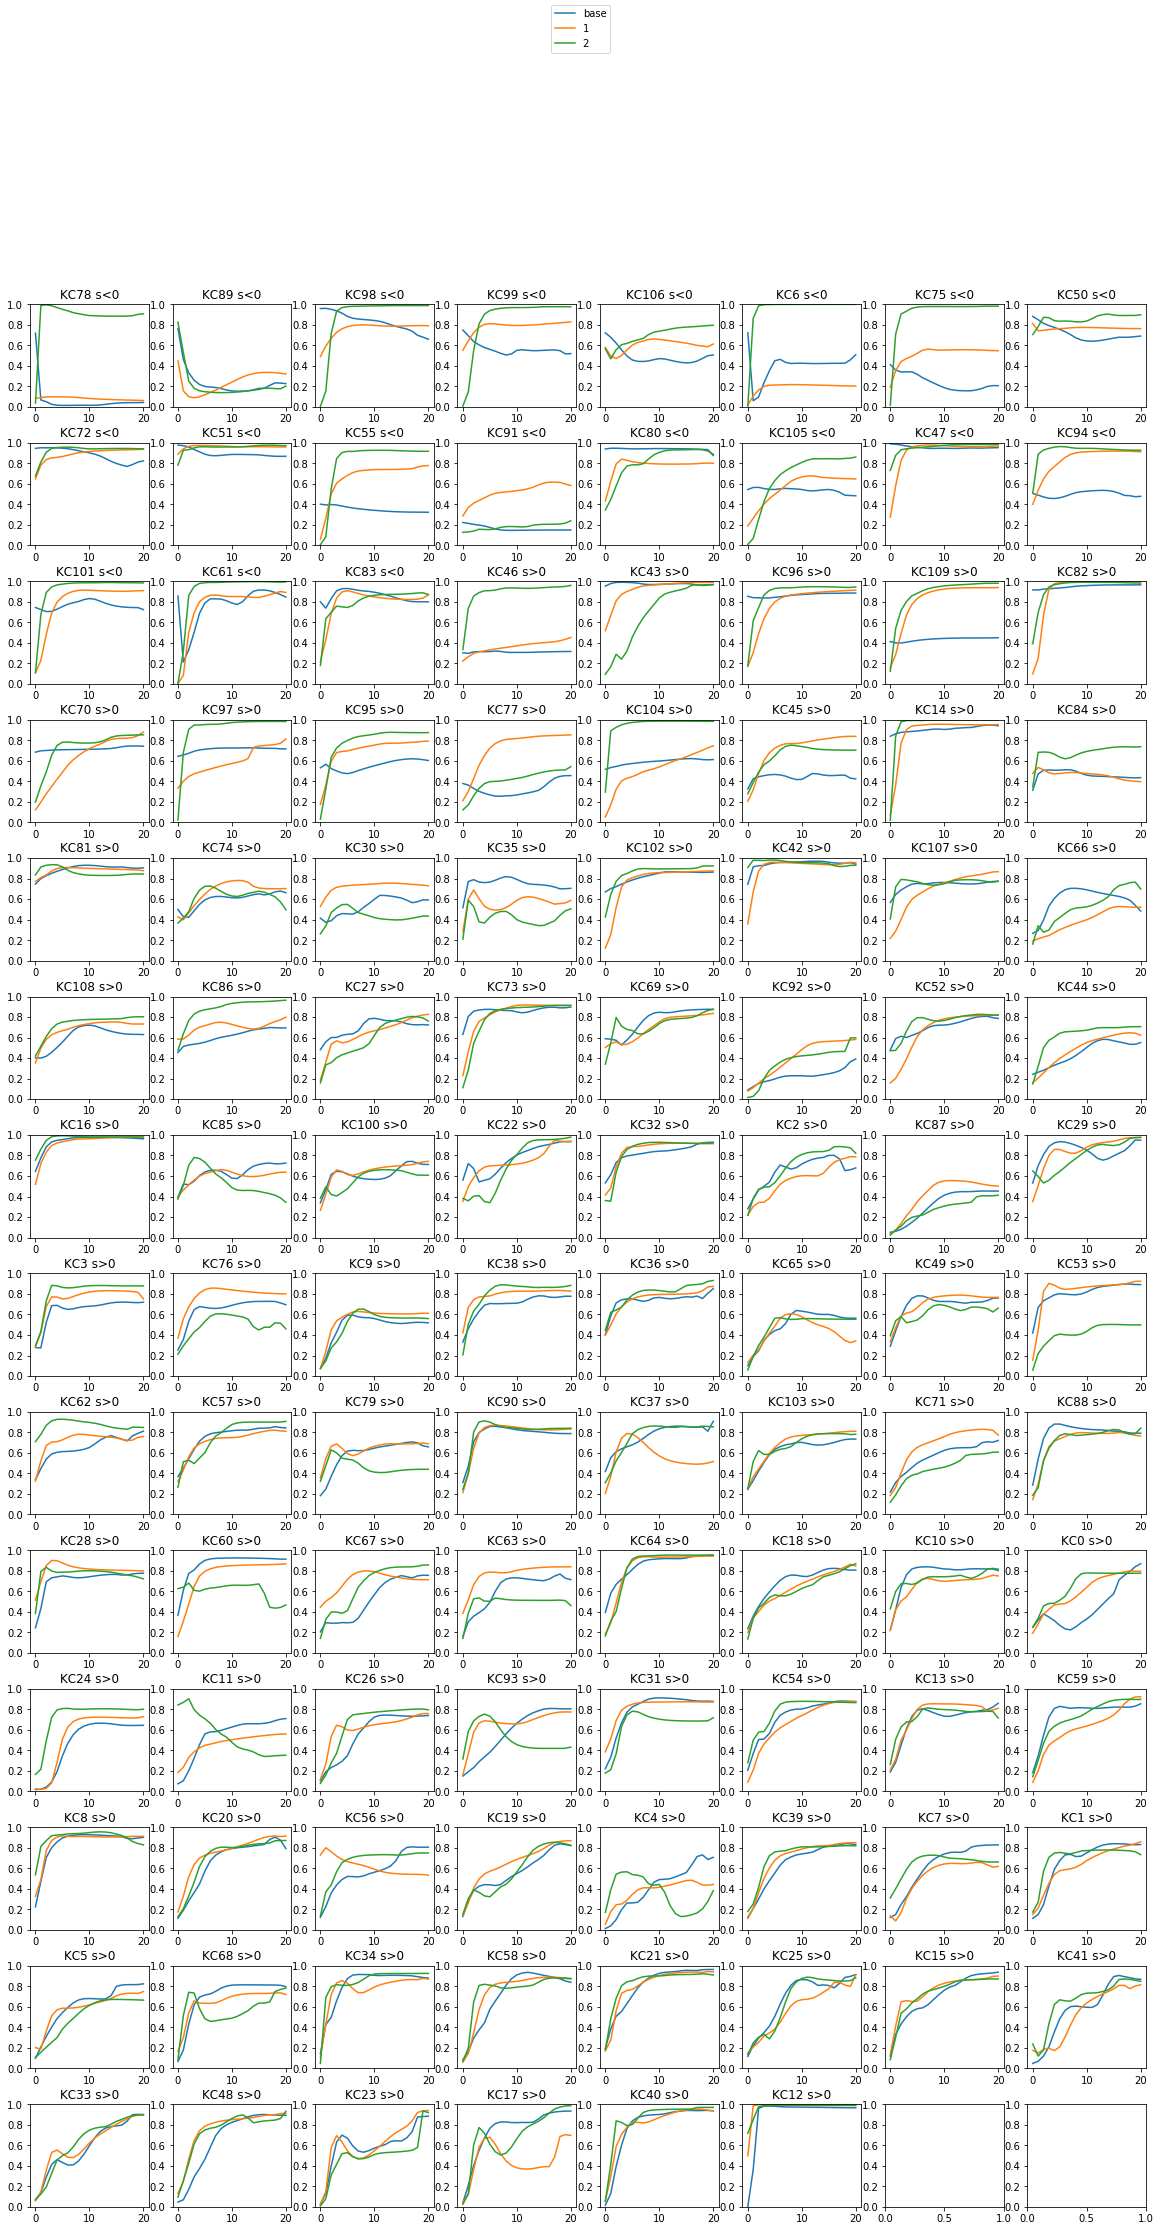

In [151]:
n_skills = report_list[base_idx]['config']['n_skills']
h, w = (n_skills+7)//8, 8
figscale = 2.5
hspace = 0.35
fig, axs = plt.subplots(h, w, figsize=(w*figscale, h*figscale))
plt.subplots_adjust(hspace=hspace)
for i, (v, (xidx, sanity)) in enumerate(list(base_res.items())[:h*w]):
    ax = axs[i//(w), i%(w)]
    ax.set_ylim([0, 1])
    ax.set_title('KC{} s{}0'.format(v, '>' if sanity[-1]>sanity[0] else '<'))
    sns.lineplot(xidx, sanity, ax=ax, label='base', palette="ch:2.5,.25")
    for i, desc_res in enumerate(descres_list):
        sns.lineplot(xidx, desc_res[v][1], ax=ax, label=str(i+1), palette="ch:2.5,.25")
    ax.get_legend().remove()
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.show()

## NDCG

pre_dummy_epoch_size0.auto	0.8858±0.1210
pre_dummy_epoch_size10.auto	0.9162±0.1031
pre_dummy_epoch_size150.auto	0.8974±0.1125


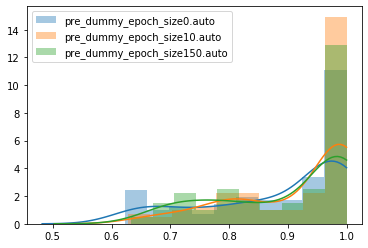

In [141]:
for rep in report_list:
    r = rep['indicator']['RPhard']['all']
    name = rep['config']['exp_name']
    sns.distplot(r, bins=10, label=name, kde_kws={'clip': (0.0, 1.0)})
    print(f'{name:<20s}\t{mean(r):.4f}±{stdev(r):.4f}')
plt.legend()
plt.show()

In [142]:
for rep in report_list:
    r = rep['indicator']['RPsoft']['all']
    name = rep['config']['exp_name']
    print(f'{name:<20s}\tGood:Bad = {r["good"]}:{r["bad"]}')

pre_dummy_epoch_size0.auto	Good:Bad = 91:19
pre_dummy_epoch_size10.auto	Good:Bad = 105:5
pre_dummy_epoch_size150.auto	Good:Bad = 106:4


## Learning curve

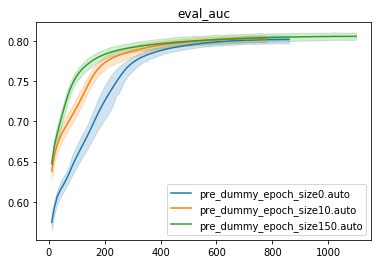

In [144]:
for r in report_list:
    show_valid_lc(r['config']['exp_name'], r['indicator'])
plt.show()

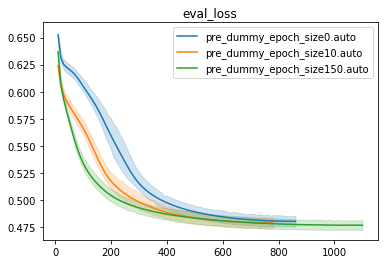

In [152]:
for r in report_list:
    show_valid_lc(r['config']['exp_name'], r['indicator'], idc='eval_loss')
plt.show()

## Test AUC

In [149]:
for r in report_list:
    summarize_test_res(r)

pre_dummy_epoch_size0.auto:	Best epoch at  862.0±66.9 	Valid AUC: 80.2291±0.6300	Test AUC: 80.2399±0.2135	All Test AUC: 80.2500
pre_dummy_epoch_size10.auto:	Best epoch at  776.0±16.7 	Valid AUC: 80.3139±0.5510	Test AUC: 80.2763±0.1107	All Test AUC: 80.4734
pre_dummy_epoch_size150.auto:	Best epoch at 1122.0±157.2	Valid AUC: 80.6169±0.5762	Test AUC: 80.5398±0.0801	All Test AUC: 80.6062


# `20_0310_edm2020_assist15`

## Simulated curve

In [115]:
config_name = '20_0310_edm2020_assist15'
report_list = []
for r in sorted([load_json(get_report_path(projectdir, e)) for e in get_exp_paths(projectdir, config_name)], key=lambda x: x['config']['pre_dummy_epoch_size']):
    report_list.append(r)

[r['config']['exp_name'] for r in report_list]

['pre_dummy_epoch_size0.auto',
 'pre_dummy_epoch_size10.auto',
 'pre_dummy_epoch_size150.auto']

In [116]:
def get_simu_res(report_dic):
    return report_dic['indicator']['simu_pred']['all']


simures_list = []
for r in report_list:
    simu_res = get_simu_res(r)
    simures_list.append(simu_res)
    

base_idx = 1
base_res = {k:v for k, v in sorted(simures_list[base_idx].items(), key=lambda it: it[1][1][-1] - it[1][1][0])}
descres_list = []
for i, simu_res in enumerate(simures_list):
    if i == base_idx:
        continue
    desc_res = {k:simu_res[k] for k in base_res.keys()}
    descres_list.append(desc_res)

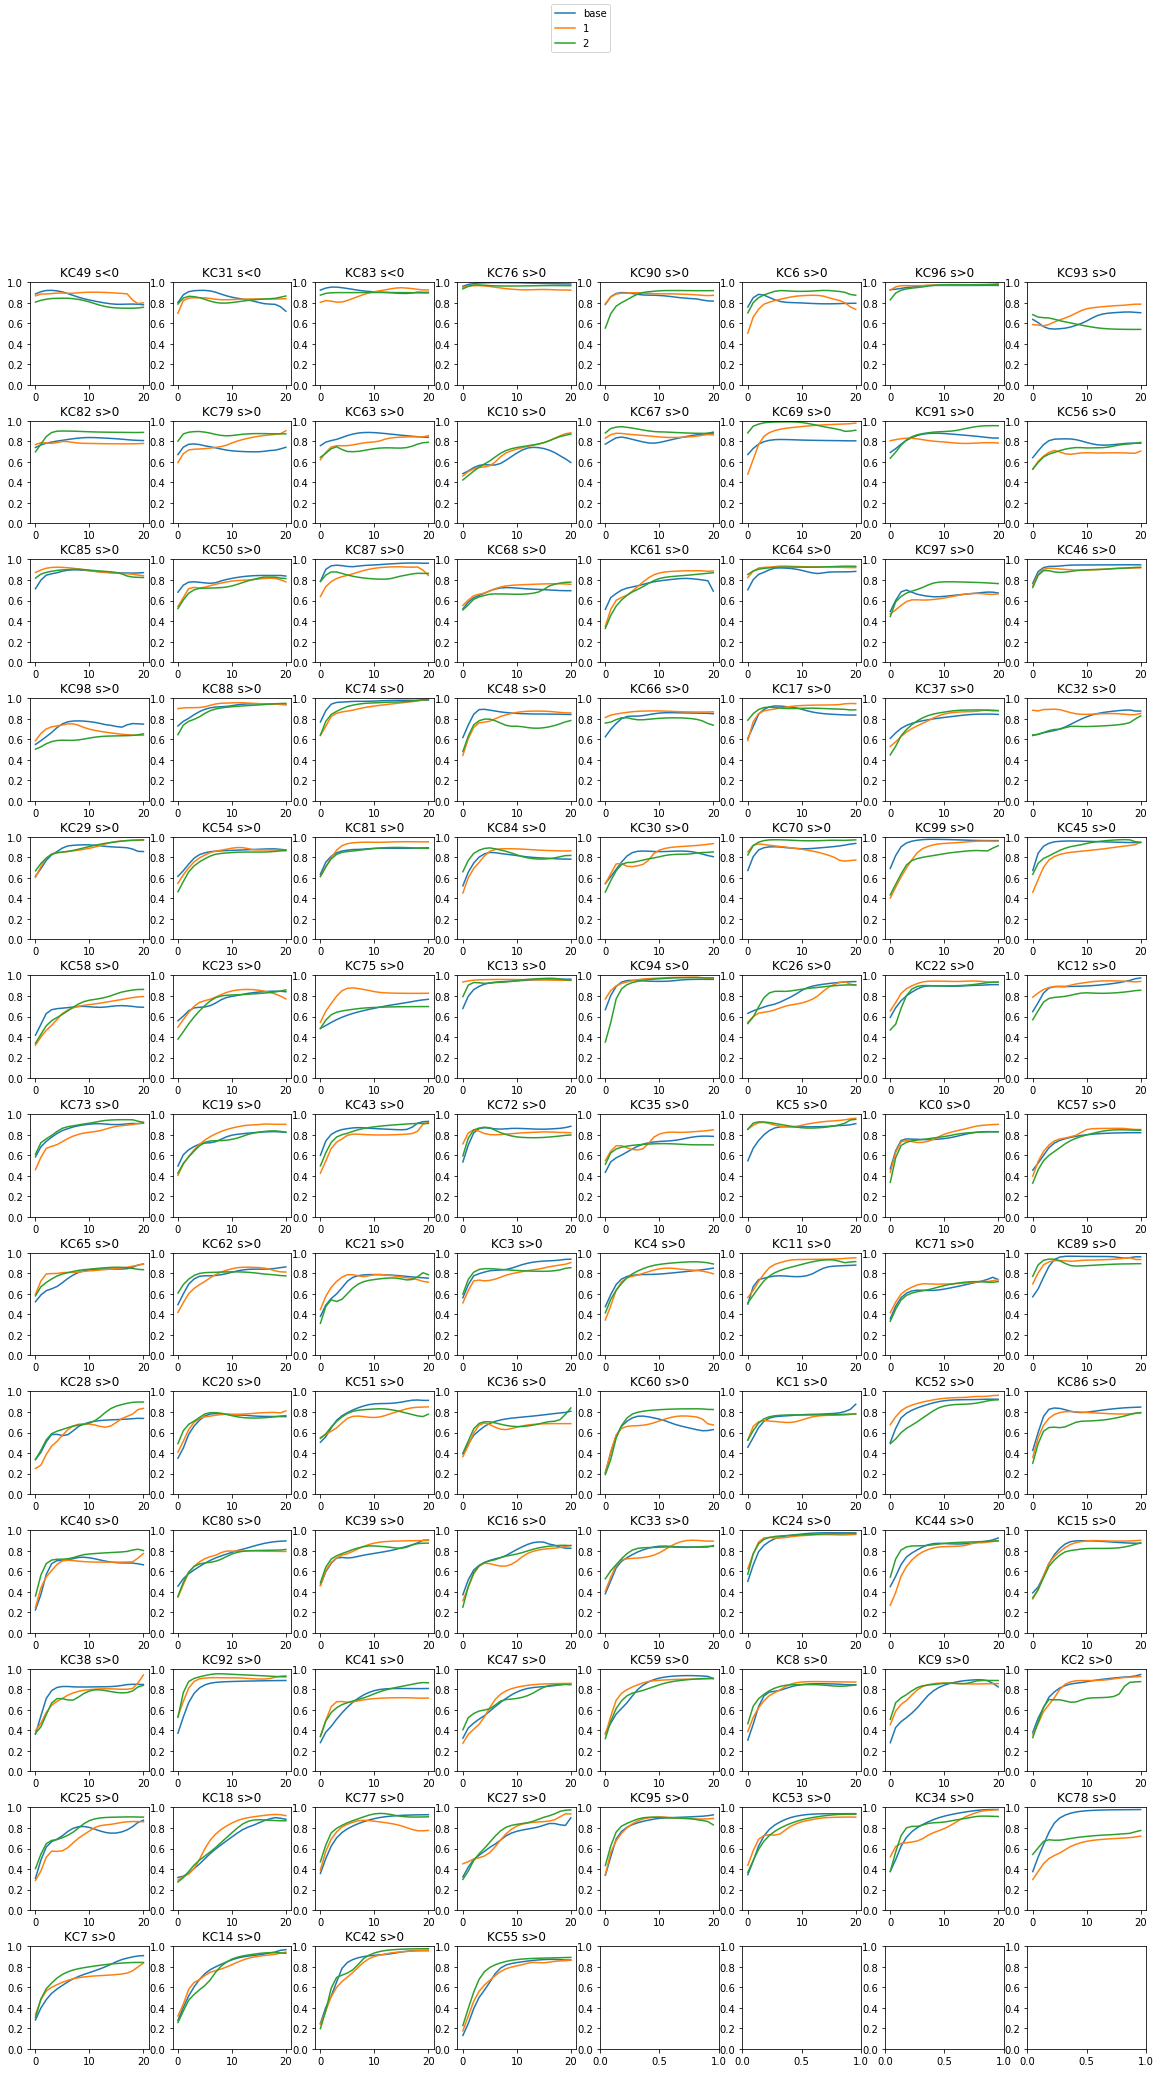

In [117]:
n_skills = report_list[base_idx]['config']['n_skills']
h, w = (n_skills+7)//8, 8
figscale = 2.5
hspace = 0.35
fig, axs = plt.subplots(h, w, figsize=(w*figscale, h*figscale))
plt.subplots_adjust(hspace=hspace)
for i, (v, (xidx, sanity)) in enumerate(list(base_res.items())[:h*w]):
    ax = axs[i//(w), i%(w)]
    ax.set_ylim([0, 1])
    ax.set_title('KC{} s{}0'.format(v, '>' if sanity[-1]>sanity[0] else '<'))
    sns.lineplot(xidx, sanity, ax=ax, label='base', palette="ch:2.5,.25")
    for i, desc_res in enumerate(descres_list):
        sns.lineplot(xidx, desc_res[v][1], ax=ax, label=str(i+1), palette="ch:2.5,.25")
    ax.get_legend().remove()
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.show()

## NDCG

pre_dummy_epoch_size0.auto	0.9177±0.1037
pre_dummy_epoch_size10.auto	0.9113±0.1079
pre_dummy_epoch_size150.auto	0.9231±0.1025


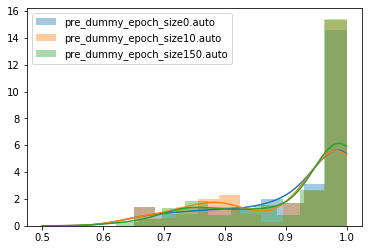

In [118]:
for rep in report_list:
    r = rep['indicator']['RPhard']['all']
    name = rep['config']['exp_name']
    sns.distplot(r, bins=10, label=name, kde_kws={'clip': (0.0, 1.0)})
    print(f'{name:<20s}\t{mean(r):.4f}±{stdev(r):.4f}')
plt.legend()
plt.show()

In [119]:
for rep in report_list:
    r = rep['indicator']['RPsoft']['all']
    name = rep['config']['exp_name']
    print(f'{name:<20s}\tGood:Bad = {r["good"]}:{r["bad"]}')

pre_dummy_epoch_size0.auto	Good:Bad = 94:6
pre_dummy_epoch_size10.auto	Good:Bad = 97:3
pre_dummy_epoch_size150.auto	Good:Bad = 96:4


## Learning curve

In [120]:
def show_valid_lc(name, idclist_dic, idc='eval_auc'):
    min_len = min([len(_x) for _x in idclist_dic['epoch'].values()])
    x = idclist_dic['epoch']['0'][:min_len] * (len(idclist_dic['epoch']) -1)  # exclude 'all'
    y = []
    for _y in idclist_dic[idc].values():
        y += _y[:min_len]
    sns.lineplot(x=x, y=y, label=name)
    plt.title(idc)
    
def show_test_lc(name, idclist_dic, idc='eval_auc'):
    x = idclist_dic['epoch']['all']
    y = idclist_dic[idc]['all']
    sns.lineplot(x=x, y=y, label=name)
    plt.title(idc)

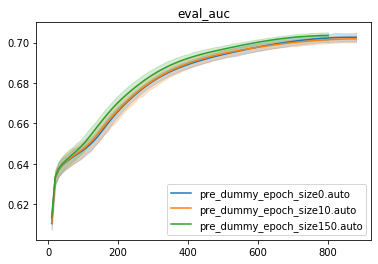

In [121]:
for r in report_list:
    show_valid_lc(r['config']['exp_name'], r['indicator'])
plt.show()

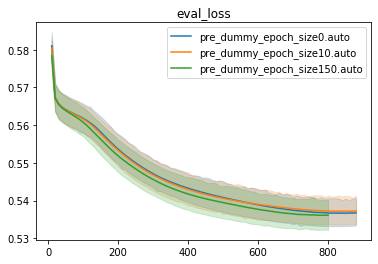

In [122]:
for r in report_list:
    show_learning_curve(r['config']['exp_name'], r['indicator'], idc='eval_loss')
plt.show()

## Test AUC

In [126]:
for r in report_list:
    summarize_test_res(r)

pre_dummy_epoch_size0.auto:	Best epoch at  884.0±28.8 	Valid AUC: 70.2695±0.2643	Test AUC: 70.3126±0.1237	All Test AUC: 70.7064
pre_dummy_epoch_size10.auto:	Best epoch at  882.0±58.9 	Valid AUC: 70.1965±0.2170	Test AUC: 70.2235±0.1363	All Test AUC: 70.3393
pre_dummy_epoch_size150.auto:	Best epoch at  804.0±24.1 	Valid AUC: 70.3530±0.2639	Test AUC: 70.2720±0.1346	All Test AUC: 70.4122


# `Debug`

## Simulated curve

In [128]:
report_list = [
    load_json(projectdir / 'output/debug/assist09/report/20200310-0530/report.json'),
    load_json(projectdir / 'output/debug/assist09pre10/report/20200310-0530/report.json')
]

[r['config']['exp_name'] for r in report_list]

['assist09', 'assist09pre10']

In [129]:
def get_simu_res(report_dic):
    return report_dic['indicator']['simu_pred']['all']


simures_list = []
for r in report_list:
    simu_res = get_simu_res(r)
    simures_list.append(simu_res)
    

base_idx = 1
base_res = {k:v for k, v in sorted(simures_list[base_idx].items(), key=lambda it: it[1][1][-1] - it[1][1][0])}
descres_list = []
for i, simu_res in enumerate(simures_list):
    if i == base_idx:
        continue
    desc_res = {k:simu_res[k] for k in base_res.keys()}
    descres_list.append(desc_res)

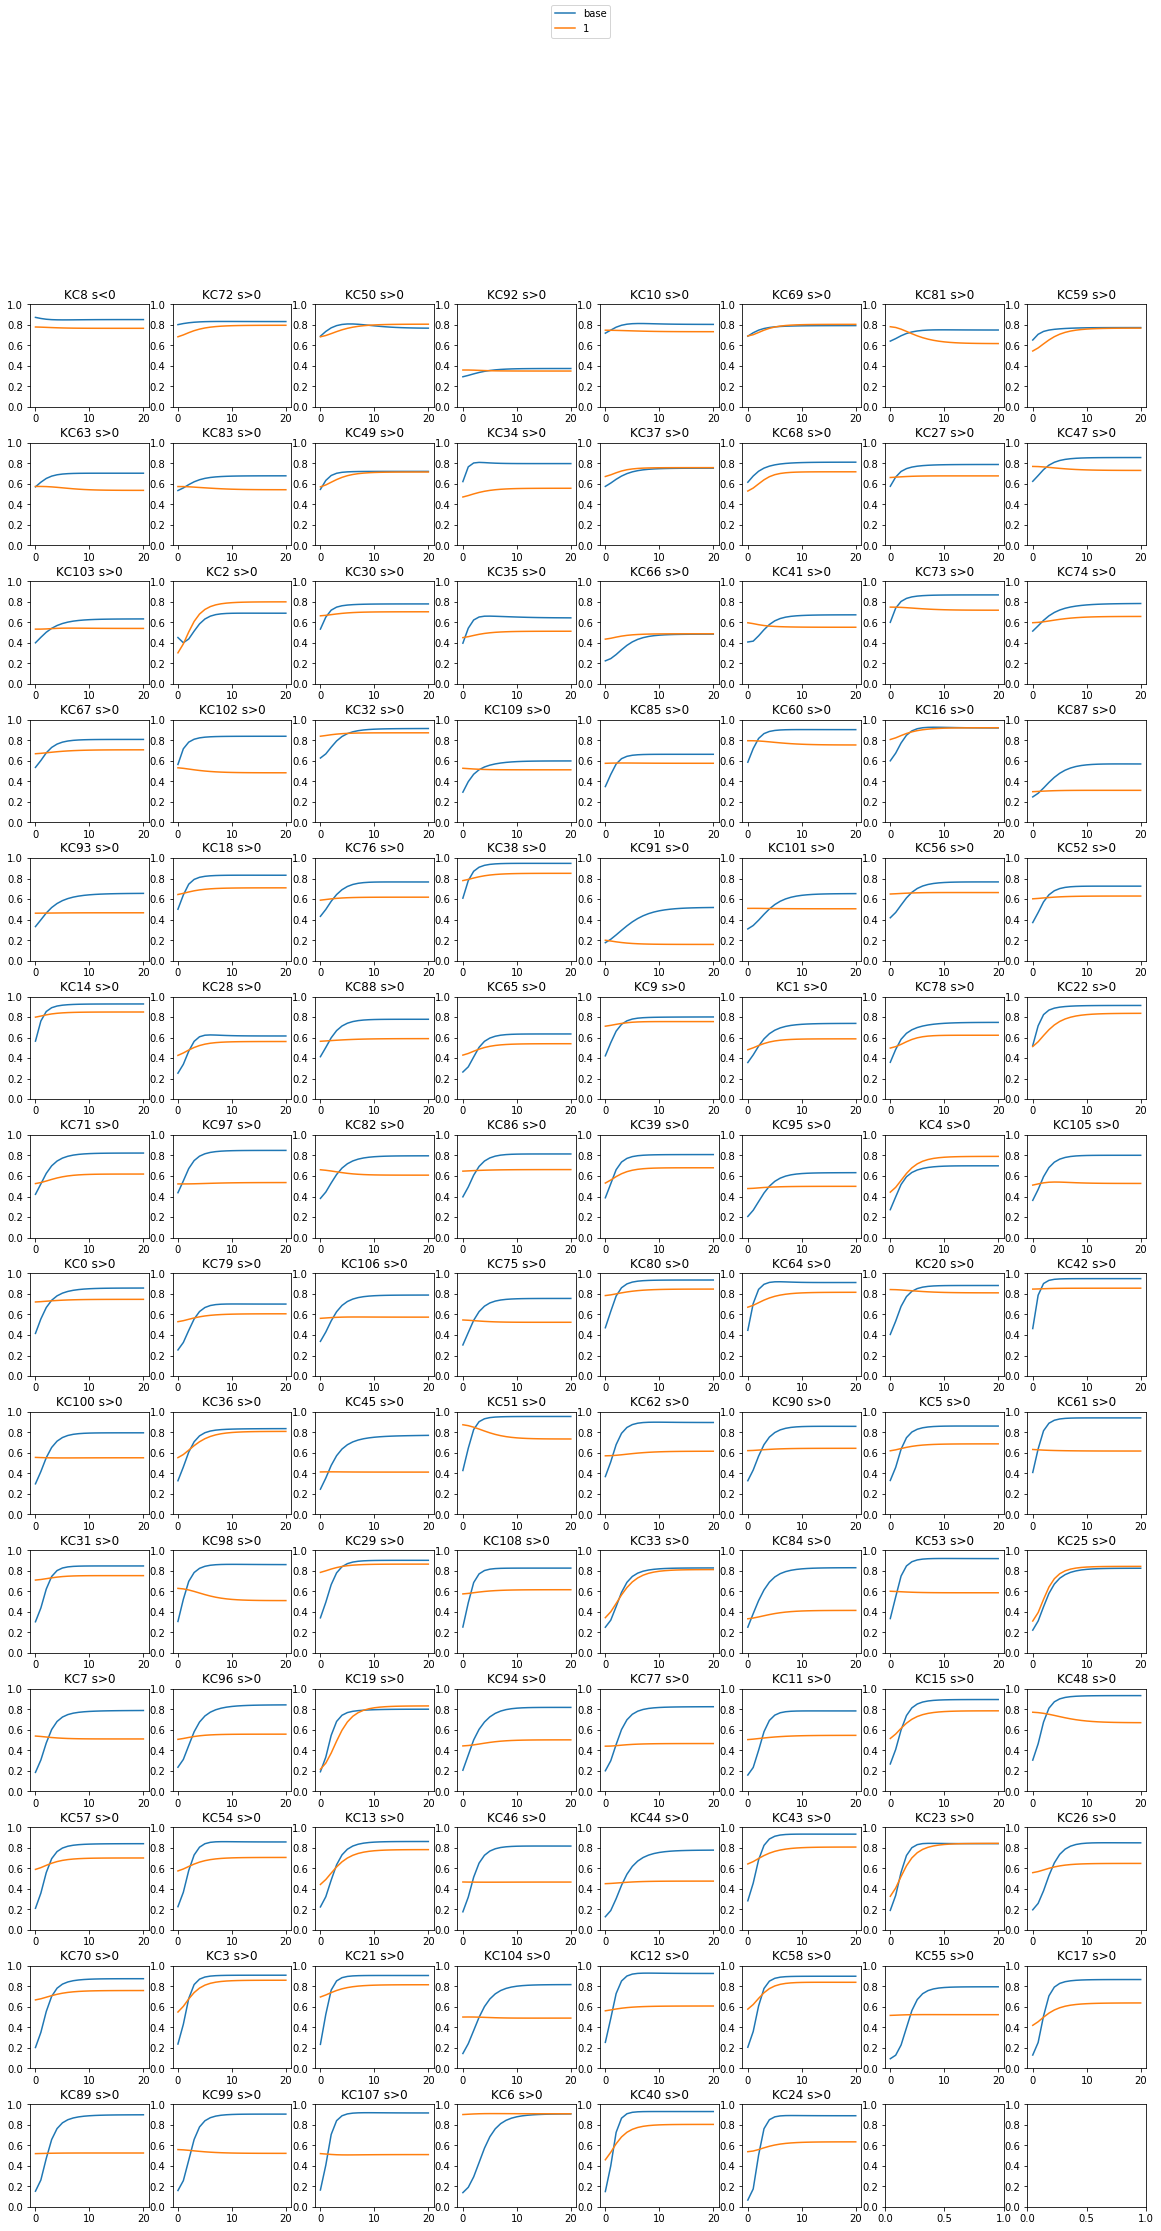

In [130]:
n_skills = report_list[base_idx]['config']['n_skills']
h, w = (n_skills+7)//8, 8
figscale = 2.5
hspace = 0.35
fig, axs = plt.subplots(h, w, figsize=(w*figscale, h*figscale))
plt.subplots_adjust(hspace=hspace)
for i, (v, (xidx, sanity)) in enumerate(list(base_res.items())[:h*w]):
    ax = axs[i//(w), i%(w)]
    ax.set_ylim([0, 1])
    ax.set_title('KC{} s{}0'.format(v, '>' if sanity[-1]>sanity[0] else '<'))
    sns.lineplot(xidx, sanity, ax=ax, label='base', palette="ch:2.5,.25")
    for i, desc_res in enumerate(descres_list):
        sns.lineplot(xidx, desc_res[v][1], ax=ax, label=str(i+1), palette="ch:2.5,.25")
    ax.get_legend().remove()
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.show()

## NDCG

assist09            	0.8841±0.1624
assist09pre10       	0.9465±0.0820


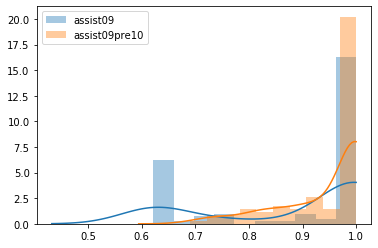

In [131]:
for rep in report_list:
    r = rep['indicator']['RPhard']['all']
    name = rep['config']['exp_name']
    sns.distplot(r, bins=10, label=name, kde_kws={'clip': (0.0, 1.0)})
    print(f'{name:<20s}\t{mean(r):.4f}±{stdev(r):.4f}')
plt.legend()
plt.show()

In [132]:
for rep in report_list:
    r = rep['indicator']['RPsoft']['all']
    name = rep['config']['exp_name']
    print(f'{name:<20s}\tGood:Bad = {r["good"]}:{r["bad"]}')

assist09            	Good:Bad = 81:29
assist09pre10       	Good:Bad = 109:1


## Learning curve

In [133]:
def show_valid_lc(name, idclist_dic, idc='eval_auc'):
    min_len = min([len(_x) for _x in idclist_dic['epoch'].values()])
    x = idclist_dic['epoch']['0'][:min_len] * (len(idclist_dic['epoch']) -1)  # exclude 'all'
    y = []
    for _y in idclist_dic[idc].values():
        y += _y[:min_len]
    sns.lineplot(x=x, y=y, label=name)
    plt.title(idc)
    
def show_test_lc(name, idclist_dic, idc='eval_auc'):
    x = idclist_dic['epoch']['all']
    y = idclist_dic[idc]['all']
    sns.lineplot(x=x, y=y, label=name)
    plt.title(idc)

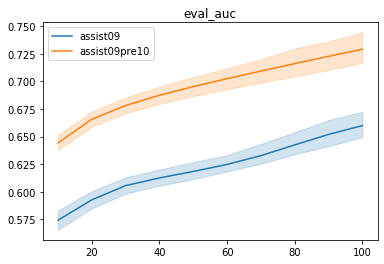

In [134]:
for r in report_list:
    show_valid_lc(r['config']['exp_name'], r['indicator'])
plt.show()

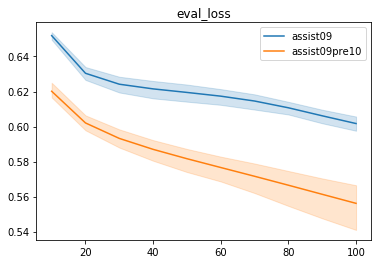

In [135]:
for r in report_list:
    show_learning_curve(r['config']['exp_name'], r['indicator'], idc='eval_loss')
plt.show()

## Test AUC

In [136]:
def summarize_test_res(rep):
    print(rep['config']['exp_name'], end=':\t')
    s = pd.Series([rep['best']['auc_epoch'][str(i)] for i in range(5)])
    print(f'Best epoch at {s.mean():>6.1f}±{s.std():<5.1f}', end='\t')
    s = pd.Series([rep['best']['auc'][str(i)] for i in range(5)])
    print(f'Valid AUC: {s.mean()*100:.4f}±{s.std()*100:.4f}', end='\t')
    s = rep['indicator']['test_auc']['all'][0]
    print(f'Test AUC: {s*100:.4f}')

In [137]:
for r in report_list:
    summarize_test_res(r)

assist09:	Best epoch at  100.0±0.0  	Valid AUC: 65.9936±1.4473	Test AUC: 67.4731
assist09pre10:	Best epoch at  100.0±0.0  	Valid AUC: 72.9030±1.7630	Test AUC: 74.9683


# `20_0310_edm2020_synthetic`

## Simulated curve

In [153]:
config_name = '20_0310_edm2020_synthetic'
report_list = []
for r in sorted([load_json(get_report_path(projectdir, e)) for e in get_exp_paths(projectdir, config_name)], key=lambda x: x['config']['pre_dummy_epoch_size']):
    report_list.append(r)

[r['config']['exp_name'] for r in report_list]

['pre_dummy_epoch_size0.auto',
 'pre_dummy_epoch_size10.auto',
 'pre_dummy_epoch_size150.auto']

In [154]:
def get_simu_res(report_dic):
    return report_dic['indicator']['simu_pred']['all']

simures_list = []
for r in report_list:
    simu_res = get_simu_res(r)
    simures_list.append(simu_res)
    
base_idx = 0
base_res = {k:v for k, v in sorted(simures_list[base_idx].items(), key=lambda it: it[1][1][-1] - it[1][1][0])}
descres_list = []
for i, simu_res in enumerate(simures_list):
    if i == base_idx:
        continue
    desc_res = {k:simu_res[k] for k in base_res.keys()}
    descres_list.append(desc_res)

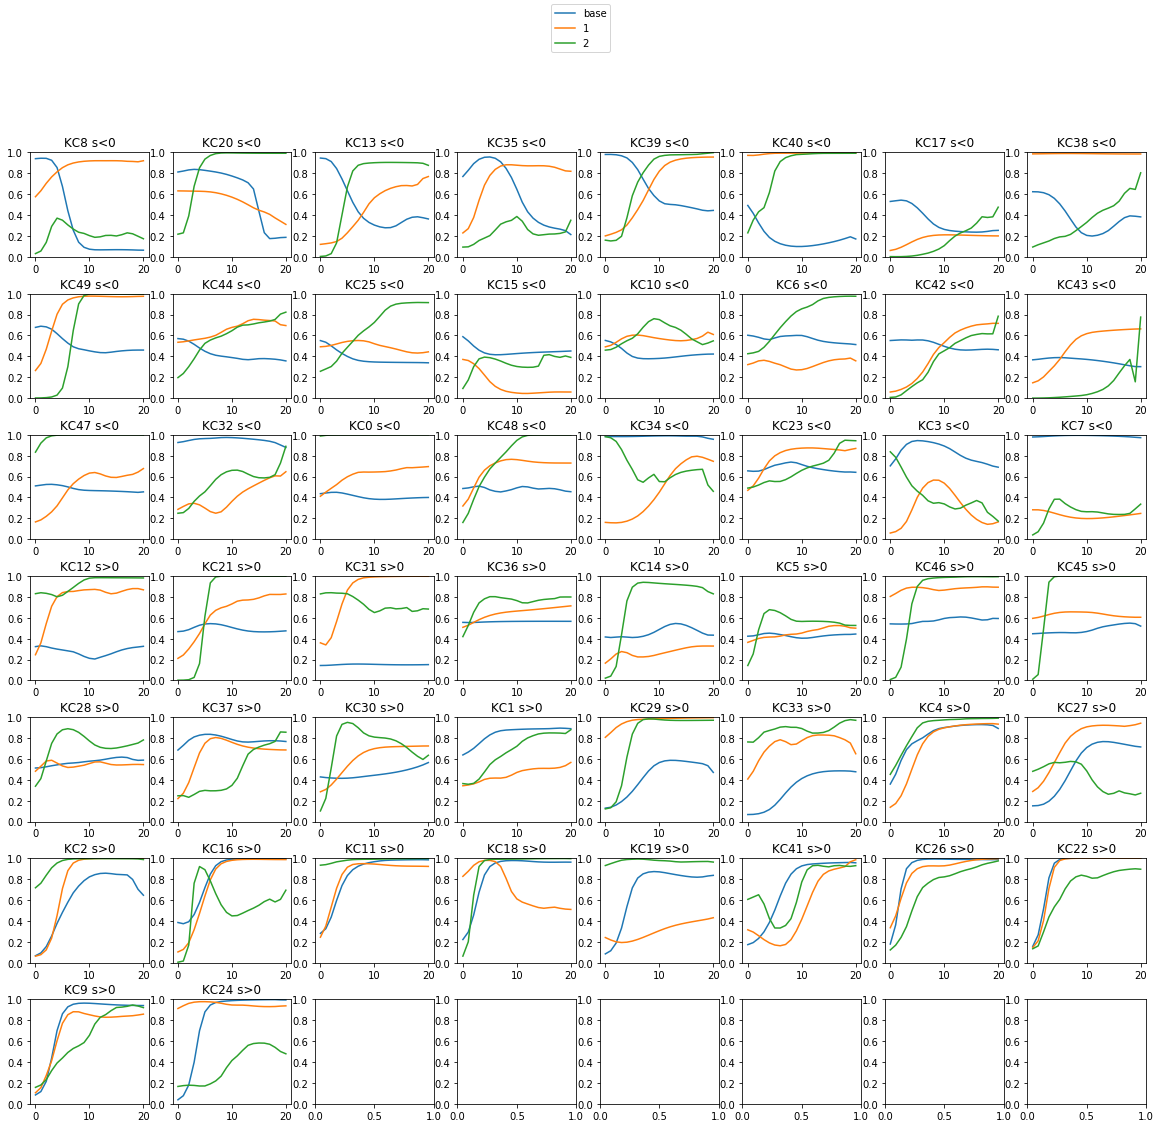

In [155]:
n_skills = report_list[base_idx]['config']['n_skills']
h, w = (n_skills+7)//8, 8
figscale = 2.5
hspace = 0.35
fig, axs = plt.subplots(h, w, figsize=(w*figscale, h*figscale))
plt.subplots_adjust(hspace=hspace)
for i, (v, (xidx, sanity)) in enumerate(list(base_res.items())[:h*w]):
    ax = axs[i//(w), i%(w)]
    ax.set_ylim([0, 1])
    ax.set_title('KC{} s{}0'.format(v, '>' if sanity[-1]>sanity[0] else '<'))
    sns.lineplot(xidx, sanity, ax=ax, label='base', palette="ch:2.5,.25")
    for i, desc_res in enumerate(descres_list):
        sns.lineplot(xidx, desc_res[v][1], ax=ax, label=str(i+1), palette="ch:2.5,.25")
    ax.get_legend().remove()
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.show()

## NDCG

pre_dummy_epoch_size0.auto	0.7923±0.1306
pre_dummy_epoch_size10.auto	0.8948±0.1156
pre_dummy_epoch_size150.auto	0.8908±0.1139


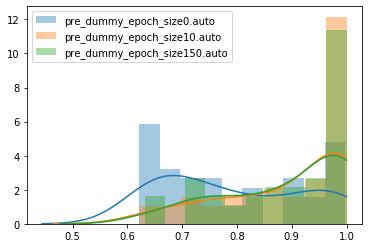

In [156]:
for rep in report_list:
    r = rep['indicator']['RPhard']['all']
    name = rep['config']['exp_name']
    sns.distplot(r, bins=10, label=name, kde_kws={'clip': (0.0, 1.0)})
    print(f'{name:<20s}\t{mean(r):.4f}±{stdev(r):.4f}')
plt.legend()
plt.show()

In [157]:
for rep in report_list:
    r = rep['indicator']['RPsoft']['all']
    name = rep['config']['exp_name']
    print(f'{name:<20s}\tGood:Bad = {r["good"]}:{r["bad"]}')

pre_dummy_epoch_size0.auto	Good:Bad = 26:24
pre_dummy_epoch_size10.auto	Good:Bad = 44:6
pre_dummy_epoch_size150.auto	Good:Bad = 46:4


## Learning curve

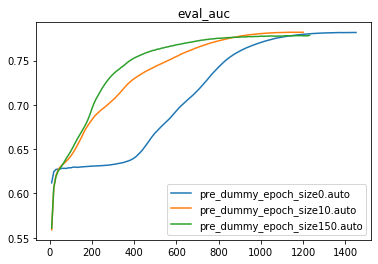

In [158]:
for r in report_list:
    show_valid_lc(r['config']['exp_name'], r['indicator'])
plt.show()

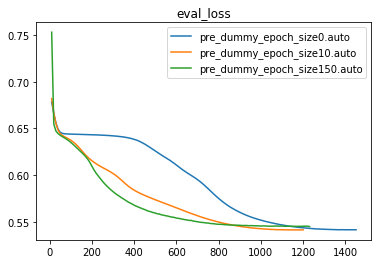

In [159]:
for r in report_list:
    show_valid_lc(r['config']['exp_name'], r['indicator'], idc='eval_loss')
plt.show()

## Test AUC

In [163]:
for r in report_list:
    summarize_test_res(r, folds=1)

pre_dummy_epoch_size0.auto:	Best epoch at 1450.0±nan  	Valid AUC: 78.1615±nan	Test AUC: 77.7116±nan	All Test AUC: 78.0250
pre_dummy_epoch_size10.auto:	Best epoch at 1200.0±nan  	Valid AUC: 78.1882±nan	Test AUC: 77.6778±nan	All Test AUC: 77.8676
pre_dummy_epoch_size150.auto:	Best epoch at 1230.0±nan  	Valid AUC: 77.8383±nan	Test AUC: 77.3313±nan	All Test AUC: 77.4381
